In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

%matplotlib inline

2023-02-07 16:22:36.826928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
data_dir = './data/cell_images'

In [4]:
os.listdir(data_dir)

['.DS_Store', 'test', 'train']

In [5]:
test_path = data_dir + '/' + 'test'
train_path = data_dir + '/' + 'train'

In [6]:
os.listdir(test_path)

['.DS_Store', 'parasitized', 'uninfected']

In [7]:
pos_train_path = test_path + '/' + 'parasitized'
neg_train_path = train_path + '/' + 'uninfected'
pos_test_path = test_path + '/' + 'parasitized'
neg_test_path = train_path + '/' + 'uninfected'

In [8]:
pos_train_cell_paths = [pos_train_path + '/' + item for item in os.listdir(pos_train_path) if item.endswith('.png')]
neg_train_cell_paths = [neg_train_path + '/' + item for item in os.listdir(neg_train_path) if item.endswith('.png')]
pos_test_cell_paths = [pos_test_path + '/' + item for item in os.listdir(pos_test_path) if item.endswith('.png')]
neg_test_cell_paths = [neg_test_path + '/' + item for item in os.listdir(neg_test_path) if item.endswith('.png')]

In [9]:
cell0 = imread(pos_train_cell_paths[0])
cell1 = imread(neg_train_cell_paths[1])

In [10]:
print(cell0.shape, cell1.shape)

(115, 112, 3) (148, 151, 3)


We will have some issues as these images are not the same shape.

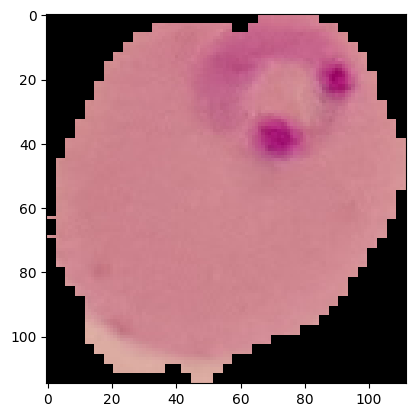

In [11]:
plt.imshow(cell0)

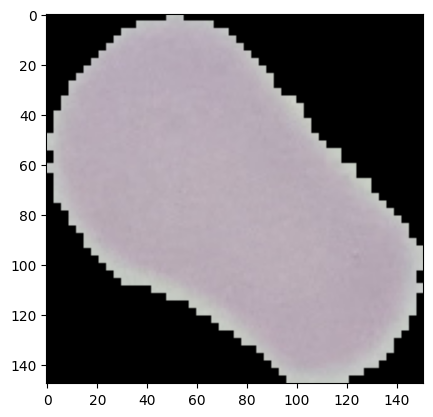

In [12]:
plt.imshow(cell1)

In [13]:
pos_train_cells = [imread(cell_path) for cell_path in pos_train_cell_paths]
neg_train_cells = [imread(cell_path) for cell_path in neg_train_cell_paths]
pos_test_cells = [imread(cell_path) for cell_path in pos_test_cell_paths]
neg_test_cells = [imread(cell_path) for cell_path in neg_test_cell_paths]

In [14]:
dim_x = []
dim_y = []
cell_class = []
dim_colors = []

for cell in pos_train_cells + pos_test_cells:
    x, y, colors = cell.shape
    dim_x.append(x)
    dim_y.append(y)
    cell_class.append(1)
    dim_colors.append(colors)
    
for cell in neg_train_cells + neg_test_cells:
    x, y, colors = cell.shape
    dim_x.append(x)
    dim_y.append(y)
    cell_class.append(0)
    dim_colors.append(colors)

In [15]:
dims_df = pd.DataFrame([dim_x, dim_y, cell_class]).T.rename(columns={0: 'dim_1', 1: 'dim_2', 2: 'class'})
dims_df

,dim_1,dim_2,class
0,115,112,1
1,118,124,1
2,127,118,1
3,118,130,1
4,154,142,1
...,...,...,...
27553,106,109,0
27554,157,124,0
27555,112,124,0
27556,121,130,0


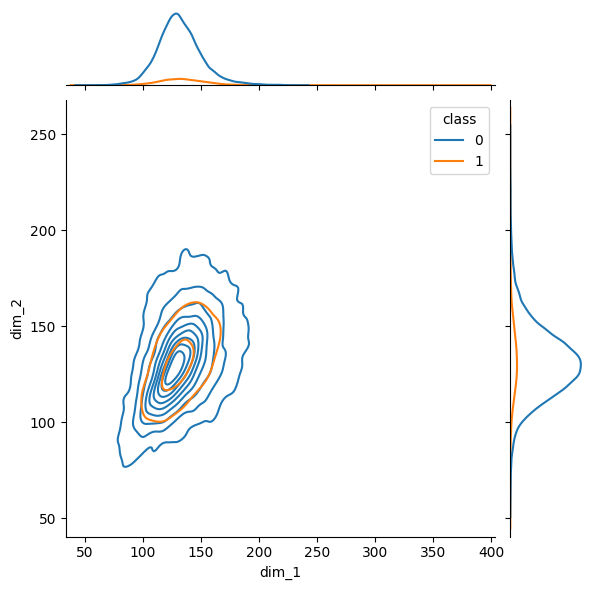

In [16]:
sns.jointplot(data=dims_df, x='dim_1', y='dim_2', hue='class', kind='kde')

In [17]:
image_shape = (int(round(np.mean(dim_x),0)), int(round(np.mean(dim_y),0)), 3)

print(f'Average dim_1 size is {image_shape[0]}')
print(f'Average dim_2 size is {image_shape[1]}')
print(f'Used image shape is {image_shape}')

Average dim_1 size is 132
Average dim_2 size is 132
Used image shape is (132, 132, 3)


This means that our average image is much larger than we were dealing with with MNIST and CIFAR10 (~20 times bigger).  Therefore, we must read the files in in batches, and not all in at once.

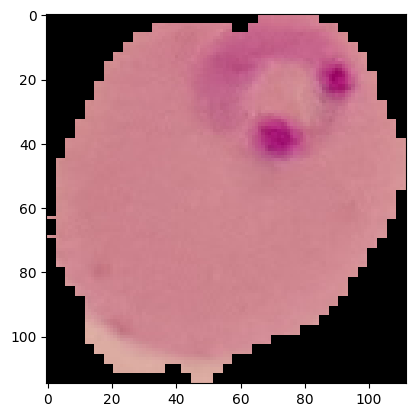

In [18]:
plt.imshow(cell0)

In [19]:
batch_size = 256

In [20]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(image_shape[0], image_shape[1]),
    batch_size=batch_size
)

Found 24958 files belonging to 2 classes.
Using 19967 files for training.
Using 4991 files for validation.


2023-02-07 16:24:06.262131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=(image_shape[0], image_shape[1]),
    batch_size=batch_size
)

Found 2600 files belonging to 2 classes.


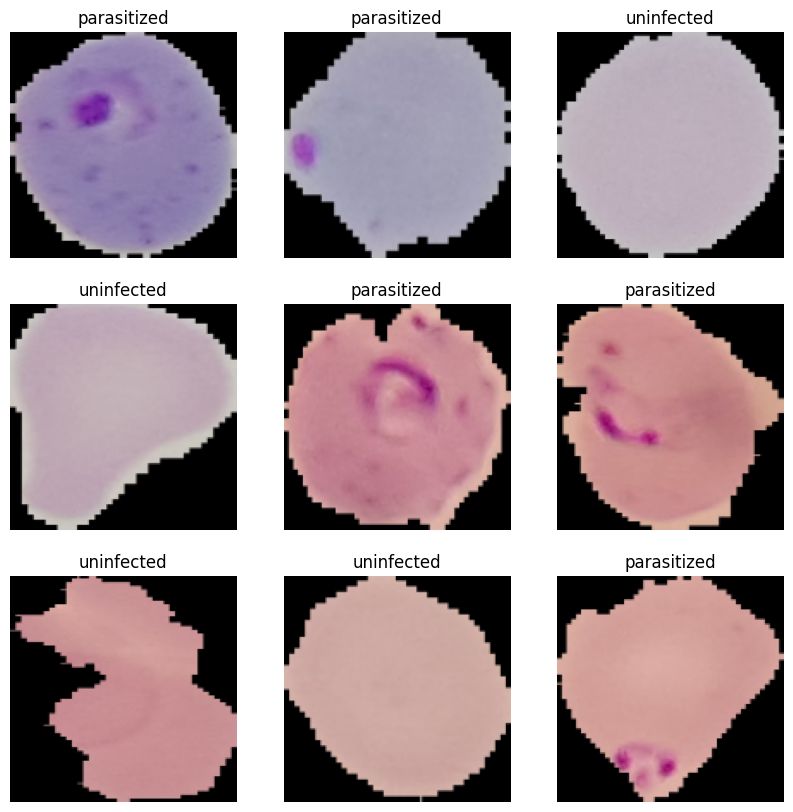

In [22]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_vals = np.fromiter(train_ds.map(lambda x, y: y), float)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_cell/simple_model/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-07--1624
cnn_cell/simple_model/fit/20230207-162408


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [27]:
simple_model = Sequential()

simple_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu')
)
simple_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
simple_model.add(Flatten())
    
simple_model.add(Dense(32, activation='relu'))
simple_model.add(Dropout(0.5))

simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 130, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 65, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 135200)            0         
                                                                 
 dense (Dense)               (None, 32)                4326432   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

In [29]:
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-07 16:24:09.079412: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-07 16:24:09.079427: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-07 16:24:09.079657: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [30]:
simple_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stop, board])

Epoch 1/20
 1/78 [..............................] - ETA: 5:21 - loss: 16.6163 - accuracy: 0.5078

2023-02-07 16:24:13.301591: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-07 16:24:13.301609: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/78 [..............................] - ETA: 1:17 - loss: 605.4550 - accuracy: 0.4961

2023-02-07 16:24:14.294726: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-07 16:24:14.307573: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-07 16:24:14.311278: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cell/simple_model/fit/20230207-162408/plugins/profile/2023_02_07_16_24_14/HOBNJML-C40PLVD.xplane.pb


78/78 [==============================] - 82s 1s/step - loss: 31.5043 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy: 0.4883
Epoch 2/20
78/78 [==============================] - 77s 983ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4883
Epoch 3/20
78/78 [==============================] - 77s 978ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.4883


Model performance was basically abismal. Let's try a deeper CNN.

In [31]:
model = Sequential()

model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu')
)
model.add(
    MaxPool2D(pool_size=(2,2))
)

model.add(
    Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape, activation='relu')
)
model.add(
    MaxPool2D(pool_size=(2,2))
)
    
model.add(
    Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape, activation='relu')
)
model.add(
    MaxPool2D(pool_size=(2,2))
)
    
model.add(Flatten())
    
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 130, 130, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)      

In [33]:
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-07 16:28:05.728923: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-07 16:28:05.728946: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-07 16:28:05.729630: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [34]:
model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stop, board])

Epoch 1/20
 1/78 [..............................] - ETA: 5:10 - loss: 9.3928 - accuracy: 0.4648

2023-02-07 16:28:09.777257: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-07 16:28:09.777271: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/78 [..............................] - ETA: 4:15 - loss: 67.4900 - accuracy: 0.4668

2023-02-07 16:28:13.129253: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-07 16:28:13.130056: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-07 16:28:13.131915: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cell/simple_model/fit/20230207-162408/plugins/profile/2023_02_07_16_28_13/HOBNJML-C40PLVD.xplane.pb


78/78 [==============================] - 183s 2s/step - loss: 2.8666 - accuracy: 0.5465 - val_loss: 0.6677 - val_accuracy: 0.5983
Epoch 2/20
78/78 [==============================] - 170s 2s/step - loss: 0.6540 - accuracy: 0.6142 - val_loss: 0.6457 - val_accuracy: 0.6490
Epoch 3/20
78/78 [==============================] - 162s 2s/step - loss: 0.6319 - accuracy: 0.6438 - val_loss: 0.6259 - val_accuracy: 0.6524
Epoch 4/20
78/78 [==============================] - 168s 2s/step - loss: 0.3887 - accuracy: 0.8463 - val_loss: 0.2044 - val_accuracy: 0.9305
Epoch 5/20
78/78 [==============================] - 188s 2s/step - loss: 0.1938 - accuracy: 0.9366 - val_loss: 0.2402 - val_accuracy: 0.9251
Epoch 6/20
78/78 [==============================] - 171s 2s/step - loss: 0.1738 - accuracy: 0.9403 - val_loss: 0.1814 - val_accuracy: 0.9307
Epoch 7/20
78/78 [==============================] - 170s 2s/step - loss: 0.1301 - accuracy: 0.9541 - val_loss: 0.1715 - val_accuracy: 0.9445
Epoch 8/20
78/78 [======

The deep model is performing much better, well enough that we should report on it.

In [35]:
metrics = pd.DataFrame(model.history.history)

<AxesSubplot: >

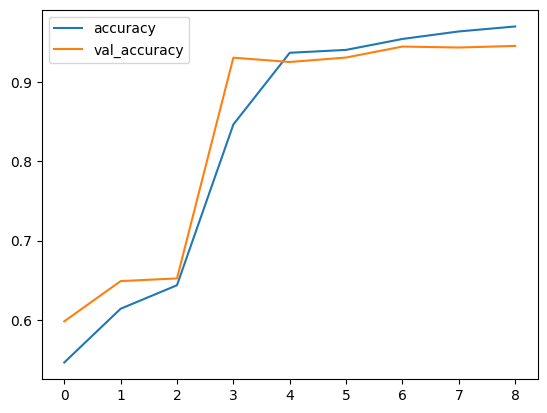

In [36]:
metrics[['accuracy', 'val_accuracy']].plot()

<AxesSubplot: >

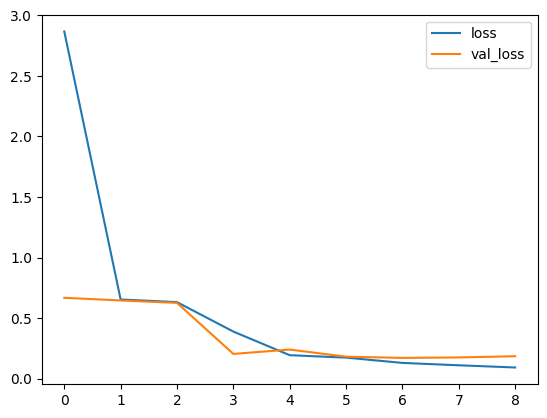

In [37]:
metrics[['loss', 'val_loss']].plot()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

In [43]:
y_test = tf.concat([y for x, y in test_ds], axis=0)

In [40]:
# Recall that 1 represents uninfected, so by requiring the
# cutoff to be high, we are saying that we are requiring our 
# model to be quite confident in order to except its labeling
# an input as 'malaria free', i.e., we are pushing for 
# a low false-positive rate (recalling that positive=1 is actually
# negative for malaria).

y_pred = model.predict(test_ds) > 0.9 

11/11 [==============================] - 8s 513ms/step


In [44]:
y_pred.sum()

1167

In [45]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1259,   41],
       [ 174, 1126]])

In [46]:
label_dict = {0: 'parasitized', 1: 'uninfected'}

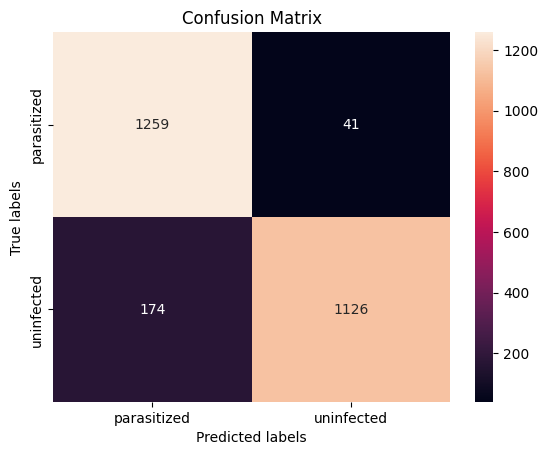

In [47]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels')
ax.set_xticklabels(label_dict.values(), rotation='horizontal')
ax.set_yticklabels(label_dict.values(), rotation='vertical')
ax.set_title('Confusion Matrix'); 

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1300
           1       0.96      0.87      0.91      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



In [59]:
y_proba = model.predict(test_ds)

11/11 [==============================] - 4s 393ms/step


In [61]:
tps = []
fps = []

for i in range(101):
    class_preds = y_proba > i/100
    cm = confusion_matrix(y_test, class_preds)
    tp = cm[0,0]/1300
    fp = cm[1,0]/1300
    tps.append(tp)
    fps.append(fp)

In [62]:
roc_data = pd.DataFrame([fps, tps]).T
roc_data = roc_data.rename(columns={0:'fpr', 1:'tpr'})

<AxesSubplot: xlabel='fpr', ylabel='tpr'>

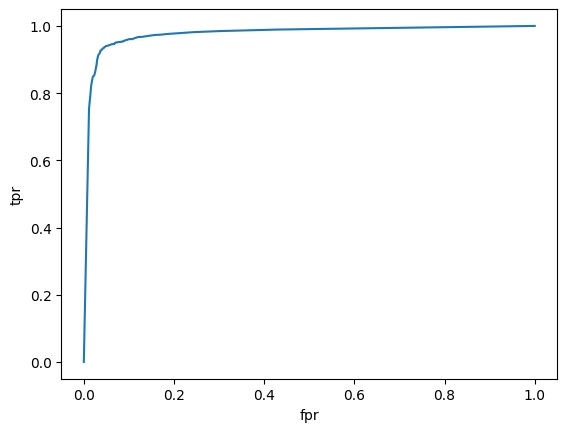

In [63]:
sns.lineplot(data=roc_data, x='fpr', y='tpr')

In [64]:
def auc_score(tps, fps):
    area = 0
    for i in range(1,len(tps)):
        area += (tps[i] + tps[i-1])/2 * (fps[i] - fps[i-1])
    return area

In [65]:
auc_score(tps, fps)

0.97635